##### Version 0.01 -- Travanj 2017

# Strujanje oko cilindra sa source-panels

Do sada smo konstruirali rješenja potencijalnog toka kojim smo mogli opisati tijela jednostavne geometrije, kao Rankine-ove oval ili cilindar u uniformnom toku. Zbrajanjem jednostavnih rješenja potencijalnog toka mogli smo "dobiti" sliku strujanja oko tijela.

Što ako želimo prikazati strujnice oko proizvoljne geometrije? Je li moguće definirati kombinaciju osnovnih rješenja kojom bi dobili očekivani rezultat? Za to je potrebno mnogo truda i sreće. 

Cilj ove lekcije je izračunati distribuciju intenziteta izvora koja rezultira potencijalnim strujanjem oko zadane geometrije: kružnog cilindra. Već smo izračunali strujanje sa doublet-om u uniformnom toku, ali ovdje pokušavamo razviti općenitiji pristup koji bi mogli kasnije proširiti na *različite* oblike.

Metoda definira tijelo sa skupom kratkih linearnih segmenata, *panela*, koji odgovaraju [source sheets](07_source_sheet.ipynb) iz prošle lekcije.

Pokušat ćemo opisati metodu koja *počinje* s definiranom geometrijom tijela, nakon čega izračunava intenzitete izvora za svaki panel kojim se treba dobiti *dividing streamlime* na granici tijela. To znači da brzina na tijelu mora biti tangencijalna. Dobro?

Počnimo uobičajenom tehnikom pisanja import modula, knjižnica itd.

In [3]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# embed the figures into the notebook
%matplotlib inline

Dodat ćemo uniformni tok veličine `u_inf`, i neka bude jednak bilo kojoj konstantnoj vrijednosti - 1:

In [4]:
u_inf = 1.0             # free-stream speed

### Definicija geometrije

Promatrat ćemo cilindar kružnog poprečnog presjeka jediničnog polumjera. Dakle, treba nacrtati točke za kut od $0$ i $2\pi$.

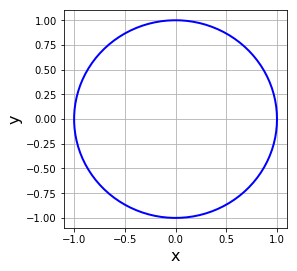

In [5]:
# define the cylinder
R = 1.0                                                           # radius
theta = numpy.linspace(0, 2*math.pi, 100)                         # angles in radians
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta)   # coordinates of the cylinder

# plot the cylinder
size = 4
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

### Diskretizacija na panele

Panel (ili dužina, linija u manje učenim krugovima) predstavlja *source sheet* i definiran je dvjema točkama(`xa`, `ya`) i (`xb`, `yb`) te svojim intenzitetom `sigma`.  Također nam je potrebno polovište panela (`xc`, `yc`) i njegova duljina, ali o tome kasnije. Orijentacija panela je definirana kutem prema $x$-osi i njegovom normalom u smjeru suprotnom od kazaljke na satu.

Intenzitet panela će ispravljati strujnice, morat ćemo imati tangencijalne brzine (normalna brzina na tijelo je jednaka nuli za neviskozno strujanje) te će biti potrebno izračunati koeficijent tlaka.

Mogi bi napisati sljedeće: Svaki panel ima svoje stanje nad kojim ćemo izvršavati metode. Odnosno, kreirat ćemo klasu `Panel` koja će sadržavati sve potrebne geometrijske podatke. Klasa će sama izračunavati polovište, duljinu i vektor normale. Inicijalizirat ćemo intenzitet, tangencijalnu brzinu i koeficijent tlaka. 

In [6]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length, and angle 
        (with the x-axis) of the panel.
        Initializes the strength of the source-sheet, the tangential velocity,
        and the pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

Formalnim rječnikom: sve diskretizacije ćemo spremiti u NumPy listu veličine `N_panels` gdje je svaki element lise objekt tipa `Panel`.

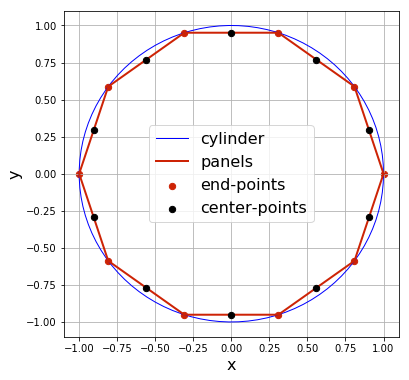

In [7]:
N_panels = 10                    # number of panels desired

# define the end-points of the panels
x_ends = R*numpy.cos(numpy.linspace(0, 2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

# define the panels
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
# plot the panels
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder,
            label='cylinder',
            color='b', linestyle='-', linewidth=1)
pyplot.plot(x_ends, y_ends,
            label='panels',
            color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels],
               label='end-points',
               color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels],
               label='center-points',
               color='k', s=40, zorder=3)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

### Rubni uvjet tangencijalnog strujanja

Ako je vektor brzine tangencijalan na panel, odnosno $u_n=0$ onda vrijedi:

$$u_n(x,y)=\frac{\partial \phi}{\partial n}(x,y)$$

na svakoj točki panela. Eh sad, napisali smo da je normalna komponenta brzine jednaka derivaciji potencijala brzine po normali. I to mora biti jednako nuli. Za točku odabiremo polovište panela koju još nazivamo *kontrolnom točkom*, ili *control point*.

The potencijal brzine [source sheet-a](07_source_sheet.ipynb) na panelu u kartezijevim koordinatama:

$$\phi\left(x,y\right) = \frac{\sigma}{2\pi} \int_\text{panel} \ln \sqrt{ \left(x-x(s)\right)^2 + \left(y-y(s)\right)^2 } {\rm d}s$$

gdje je $s$ koordinata duž panela i $\left(x(s),y(s)\right)$ su kartezijeve koordinate varijable $s$.

Superpozicija potencijala svakog panela daje ukupni potencijal na bilo kojoj točki $\left(x,y\right)$, čime zbrojimo sve doprinose panela (primijetite da smo pomakli eksponent $\frac{1}{2}$ u logaritamskom članu kao faktor izvan integrala:

$$\phi\left(x,y\right) = \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left( \left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2 \right) {\rm d}s_j$$

Na kraju dodajemo uniformni tok i strujanje oko cilintra može biti prikazano sljedećim potencijalom brzina:

$$\phi\left(x,y\right) = U_\infty x + \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left( \left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2 \right) {\rm d}s_j$$

Kako zahtijevamo da brzine budu tangencijalne na svakoj *kontrolnoj točki*, time geometrija tijela *približno* odgovara *dividing* strujnici (ovo približno postaje sve točnije ako dodajemo više panela). 

Dakle, za svaki panel $i$, zahtijevamo da vrijedi $u_n=0$ pri $(x_{c_i},y_{c_i})$:

$$u_{n_i} = \frac{\partial}{\partial n_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace = 0$$

što nas dovodi do

$$0 = U_\infty \cos\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial n_i}
+ \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial n_i}
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$

gdje je $\beta_i$ kut normale panela s $x$ osi, odnosno

$$\frac{\partial x_{c_i}}{\partial n_i} = \cos\beta_i \quad \text{i}\quad\frac{\partial y_{c_i}}{\partial n_i} = \sin\beta_i$$

i

$$x_j(s_j) = x_{a_j} - \sin\left(\beta_j\right) s_j$$
$$y_j(s_j) = y_{a_j} + \cos\left(\beta_j\right) s_j$$

A što ako je $i=j$? Znamo da intenziteti moraju biri određene veličine ako ne želimo da strujnice uđu u panel. To nam omogućuje izračunati doprinos $i$-tog panela na sebe, a to je $\frac{\sigma_i}{2}$.

Napokon, rubni uvjet na polovištu $i$-tog panela:

$$0 = U_\infty \cos\beta_i + \frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$

Iz gornje jednadžbe, jasno nam je da trebamo izračunati integrale pomoću SciPy funkcije `integrate.quad()`. Definirat ćemo funkciju `integral_normal()`.

In [8]:
def integral_normal(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrand(s):
        return ( (+(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]

### Rješavanje sustava jednadžbi

Upravo smo izveli jednadžbu kojom zahtijevamo tangencijalno strujanje na $i$-ti panel. Ali postoji `N_panels` panela $i$ i `N_panels` nepoznatih intenziteta $\sigma_i$. Odnosno, potrebno je riješiti sustav linearnih jednadžbi oblika

$$[A][\sigma] = [b]$$

gdje je 

$$A_{ij} = \begin{cases}
\begin{matrix}
\frac{1}{2} & \mbox{, if } i=j \cr
\frac{1}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} ds_j & \mbox{, if } i\neq j
\end{matrix}
\end{cases}$$

i

$$b_i = - U_\infty \cos\beta_i$$

za $1\leq i,j \leq N_p$. "Napunimo" matricu $A$ i vektor rješenja $b$ s potrebnim podacima:

In [9]:
# compute the source influence matrix
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_normal(p_i, p_j)

# compute the RHS of the linear system
b = - u_inf * numpy.cos([p.beta for p in panels])

Primijetite korištenje Python funkcije [enumerate()](https://docs.python.org/2/library/functions.html#enumerate). Time možemo pristupite svakom elementu `panel` u listi `panels` i pratiti indeks u listi `i` (koji  počinje s `0`, kako i priliči) da bi mogli lociirati koji element u `A` treba "napuniti".

Rješavamo linearni sustav s funkcijom [`linalg.solve()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) iz NumPy knjižnice i dodjeljujemo svakom panelu odgovarajući intenzitet:

In [10]:
# solve the linear system
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

### Pressure coefficient na površini objekta

Do sada smo uspjeli izračunati intenzitete izvora za svaki panel i dobili strujnice oko naše geometrije. Sada možemo izračunati koeficijent tlaka na površini objekta.

Iz Bernouolli-jeva jednadžbe, koeficijent tlaka na $i$-tom panelu je 

$$C_{p_i} = 1-\left(\frac{u_{t_i}}{U_\infty}\right)^2$$

gdje je $u_{t_i}$ tangencijalna komponenta brzine na polovištu$i$-tog panela,

$$u_{t_i} = \frac{\partial}{\partial t_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace$$

a može se izračunati kao:

$$u_{t_i} = -U_\infty \sin\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial t_i}
+ \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial t_i}
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$

s

$$\frac{\partial x_{c_i}}{\partial t_i} = -\sin\beta_i \quad\text{and} \quad \frac{\partial y_{c_i}}{\partial t_i} = \cos\beta_i$$

Primijetite da je doprinos tangencijalne komponente na panel iz vlastitog potencijala nula. 

Definirat ćemo funkciju `integral_tangential()` koja će izračunati gornje integrale sa SciPy funkcijom `integrate.quad()`, ali to ste već i znali:

In [11]:
def integral_tangential(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrand(s):
        return ( (-(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.sin(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.cos(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [12]:
# compute the matrix of the linear system
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_tangential(p_i, p_j)

# compute the RHS of the linear system
b = - u_inf * numpy.sin([panel.beta for panel in panels])

# compute the tangential velocity at each panel center-point
vt = numpy.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

Jednom kada izračunamo tangencijalnu komponentu brzine, možemo izračunati koeficijent tlaka:

In [13]:
# calculate the surface pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt/u_inf)**2

Vrijeme je za crtanje.

Baš kao što je već jednom pokazano u lekciji [doublet](03_dublet.ipynb), egzaktan koeficijent tlaka na površini cilindra iznosi

$$Cp = 1 - 4\sin^2 \theta$$

odnosno

$$Cp = 1 - 4\left(\frac{y}{R}\right)^2$$

Možemo usporediti analitičke rezultate s rezultatima dobivenim pomoću source-panel metode.

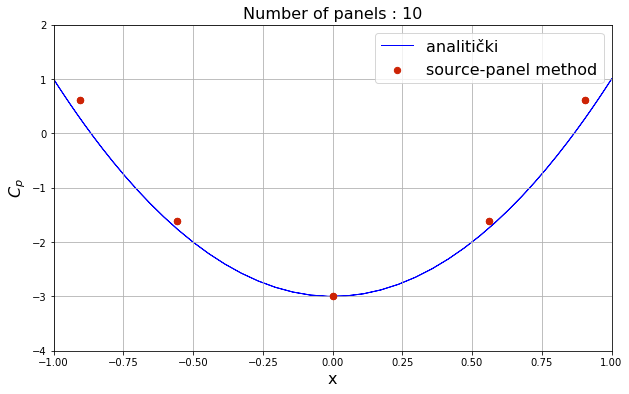

In [14]:
# calculate the analytical surface pressure coefficient
cp_analytical = 1.0 - 4*(y_cylinder/R)**2

# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(x_cylinder, cp_analytical,
            label='analitički',
            color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels],
               label='source-panel method',
               color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.0, 1.0)
pyplot.ylim(-4.0, 2.0);

##### Zadatak

Bilo bi zanimljivo vidjeti kako izgledaju strujnice za ovakvo strujanje

Možemo koristiti funkciju `streamplot()` iz Matplotlib knjižnice, za što nam trebaju komponente brzina (`u`,`v`) na mreži (`X`,`Y`). Prvi korak je izvesti jednadžbe za komponente brzina.

Potencija u točki $\left(x,y\right)$ s of the $N_p$ source sheets in a uniform horizontal flow $U_\infty$ is

$$\phi\left(x,y\right) = U_\infty x + \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left( \left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2 \right) {\rm d}s_j$$

A polje brzina u točki $\left(x,y\right)$ je 

$$u\left(x,y\right) = \frac{\partial}{\partial x}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

$$v\left(x,y\right) = \frac{\partial}{\partial y}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

Morat ćete :

* izvesti komponente brzina u kartezijevim koordinatama
* kreirati numeričku mrežu
* izračunati polje brzina na to mreži
* iscrtati rezultate
* promijeniti broj panela da poboljšamo vizualizacijuchange the number of panels to improve the visualization

---

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()